In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, datasets
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision

import copy
import time
import os

use_gpu=False

In [2]:
# Traning Protocols
BatchSize = 16 # Batch size in the data loader
NumEpochs = 10 # Number fo epochs to train over

# Location of the images folders
data_dir = '/home/proto/Documents/unittest/data/'

# Details the transforms and the order in which they are applied on the input data for making the input training data robust to variations in input image appearance. However no transforms are applied to the validation data to keep it simple at the dataloader.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([32,32]), 
        #transforms.RandomAffine(45, translate=(0.1, 0.1)),
        #transforms.RandomCrop(28),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor()]), # Incorporate multiple jitters, rotation, flip, translation deformations in the trainign data to make it robust
    'val': transforms.Compose([
        transforms.Resize([32,32]),
        transforms.ToTensor()]), # Just resize the images to match the 64x64 input size
	}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
	data_transforms[x])
	for x in ['train', 'val']} # This maps the transforms to the respective datasets
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], 
	batch_size=BatchSize, shuffle=True, num_workers=4)
	for x in ['train', 'val']} # This loads the data from the hard disk drive location per batch with transforms applied

In [3]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} # Size fo the dataset
print('Dataset size: '+str(dataset_sizes))
train_class_names = image_datasets['train'].classes # Use the class names same as the folder names for images of each class
print('Names of training classes: '+str(train_class_names))
val_class_names = image_datasets['val'].classes # Use the class names same as the folder names for images of each class
print('Names of validation classes: '+str(val_class_names))

Dataset size: {'train': 240, 'val': 20}
Names of training classes: ['0', '1']
Names of validation classes: ['0', '1']


In [4]:
# Define the training routine as a function
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time() # Start monitoring the time to execute routine

    best_model_wts = model.state_dict() # Watch and save the model weights at start to enable starting by loading a pre-trained model
    best_acc = 0.0 # Temporary variable to monitor the accuracy on validation set
    trainLoss = []
    trainAcc = []
    valLoss = []
    valAcc = []
    # Start the epoch processing counter
    for epoch in range(num_epochs): 
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase, so set the model update and internal variable management suitable to each phase. Gradients are not accumulated and weights are not updated in Validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # Wrap the inputs and labels in a Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass over the network
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # collect performance statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.item() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                torch.save(model, './model.pth') # Save the model after every epoch
            if phase == 'train':
                trainLoss.append(epoch_loss)
                trainAcc.append(epoch_acc)
            if phase == 'val':
                valLoss.append(epoch_loss)
                valAcc.append(epoch_acc)
    
        # Plotting training loss vs Epochs
        fig1 = plt.figure(1)        
        if epoch == 0:
            plt.plot(range(epoch+1),trainLoss,'r-', range(epoch+1),valLoss,'b-',label=['train','val'])
            plt.legend(loc='upper left')
            plt.xlabel('Epochs')
            plt.ylabel('Cross Entropy Loss')
        else:
            plt.plot(range(epoch+1),trainLoss,'r-', range(epoch+1),valLoss,'b-')
        plt.savefig('./Loss.png')

        # Plotting testing accuracy vs Epochs
        fig2 = plt.figure(2)        
        if epoch == 0:
            plt.plot(range(epoch+1),trainAcc,'r-', range(epoch+1),valAcc,'b-',label=['train','val'])        
            plt.legend(loc='upper left')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
        else:
            plt.plot(range(epoch+1),trainAcc,'r-', range(epoch+1),valAcc,'b-') 
            plt.title('Best val accuracy: '+str(best_acc)+' at epoch '+str(best_epoch))       
        plt.savefig('./Accuracy.png')

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
class ModLeNet(nn.Module):
    def __init__(self):
        super(ModLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(1600, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 1600)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [6]:
inp=torch.Tensor(16,3,32,32)
print(inp.size())
model = ModLeNet()
out = model(inp)
print(out.size())

torch.Size([16, 3, 32, 32])
torch.Size([16, 2])


/home/proto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
print(model)

ModLeNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


ModLeNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
Epoch 1/10
----------


/home/proto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 0.0436 Acc: 0.4542
val Loss: 0.0689 Acc: 0.5000


/home/proto/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type ModLeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2/10
----------
train Loss: 0.0428 Acc: 0.5917
val Loss: 0.0659 Acc: 0.5500
Epoch 3/10
----------
train Loss: 0.0403 Acc: 0.6708
val Loss: 0.0568 Acc: 0.6000
Epoch 4/10
----------
train Loss: 0.0420 Acc: 0.5875
val Loss: 0.0584 Acc: 0.5000
Epoch 5/10
----------
train Loss: 0.0396 Acc: 0.6833
val Loss: 0.0578 Acc: 0.6500
Epoch 6/10
----------
train Loss: 0.0385 Acc: 0.6792
val Loss: 0.0494 Acc: 1.0000
Epoch 7/10
----------
train Loss: 0.0340 Acc: 0.7167
val Loss: 0.0497 Acc: 0.8000
Epoch 8/10
----------
train Loss: 0.0354 Acc: 0.7083
val Loss: 0.0574 Acc: 0.6000
Epoch 9/10
----------
train Loss: 0.0332 Acc: 0.7417
val Loss: 0.0392 Acc: 0.9500
Epoch 10/10
----------
train Loss: 0.0301 Acc: 0.7667
val Loss: 0.0371 Acc: 0.7000

Training complete in 0m 11s
Best val Acc: 1.000000


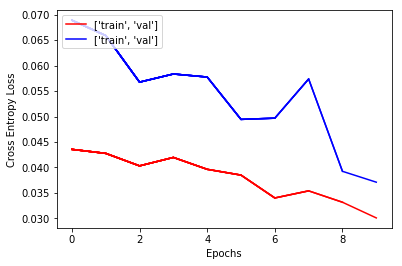

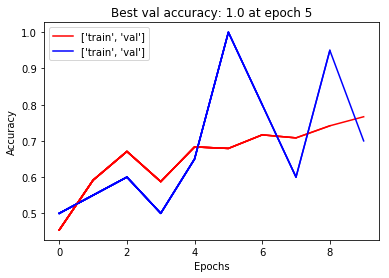

In [8]:
# Initialize the model per detinition
model_ft = ModLeNet()
print(model_ft)

# Define the loss function or traning criterion
criterion = nn.CrossEntropyLoss()
# Define the optimizer to be used and observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
# Start training the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,NumEpochs)